In [327]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score 
dataControl = pd.read_csv('PARData_Control_202310181008.csv') #Read in data from CSV
data = pd.read_csv('PARData_Test_202310181010.csv') #Read in data from CSV
dataControl.columns = ["Time","Volt"]


data['time'] = pd.to_datetime(data['time'], format='%Y-%m-%d %H:%M:%S')
data = data.sort_values(by='time', ascending=True)
dataControl['Time'] = pd.to_datetime(dataControl['Time'], format='%Y-%m-%d %H:%M:%S')
# print(dataControl)

#RESAMPLE to 15 minute interval
data = data.set_index('time')
data = data.resample('1H').mean()
data.dropna(axis='rows')

dataControl = dataControl.set_index('Time')
dataControl = dataControl.resample('1H').mean()
dataControl.dropna(axis='rows')
# print(dataControl)
# print(data)
data.info()
dataControl.info()

#DATA CLEANING/NORMALIZING
par = dataControl['Volt'] - min(dataControl['Volt']) #Remove offset from ADC
# par = par/np.nanmean(par) #Normalize
par = par*100; #Convert to umol m^-2 s^-1
dataControl.insert(1, 'PAR', par, True)

# data["BLUE"] = data["BLUE"]/np.nanmean(data["BLUE"]) #Normalize
# data["RED"] = data["RED"]/np.nanmean(data["RED"]) #Normalize
# data["GREEN"] = data["GREEN"]/np.nanmean(data["GREEN"]) #Normalize

#GROUP 
dataTotal = data.join(dataControl)
dataTotal = dataTotal.dropna(axis='rows')
# dataTotal = dataTotal.loc['2023-10-12':'2023-10-15']
dataTotal['PAR_EST'] = dataTotal["BLUE"]*2391 #Use optimal scaling, found below
# dataTotal['PAR_EST'] = dataTotal['PAR_EST']/np.nanmean(dataTotal['PAR_EST'])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 203 entries, 2023-10-09 23:00:00 to 2023-10-18 09:00:00
Freq: H
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RED     203 non-null    float64
 1   GREEN   203 non-null    float64
 2   BLUE    203 non-null    float64
dtypes: float64(3)
memory usage: 6.3 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 203 entries, 2023-10-10 00:00:00 to 2023-10-18 10:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Volt    203 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


0.6223423194675834


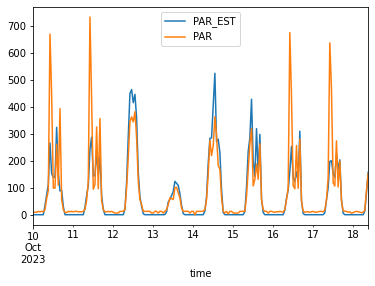

In [328]:
# dataPlot = dataTotal.loc['2023-10-12':'2023-10-15'] #Subsample of data for plotting/analysis
dataPlot = dataTotal #Use all data
# dataPlot = dataPlot.resample('1H').mean()
# dataPlot['PAR_EST'] = dataPlot['PAR_EST']/np.nanmean(dataPlot['PAR_EST'])

dataPlot.plot(y = ["PAR_EST", "PAR"], use_index=True)

r_squared = r2_score(dataPlot["PAR"], dataPlot["PAR_EST"])
print(r_squared)

In [237]:
#FIND OPTIMAL COEFFICIENTS 
r_max = 0
a_max = 0
b_max = 0
for a in range(100):
    for b in range(100):
        dataTotal['PAR_EST'] = a*dataTotal["TCS3400.0.LIGHT_BLUE"] + b*dataTotal["TCS3400.0.LIGHT_RED"]
        dataTotal['PAR_EST'] = dataTotal['PAR_EST']/statistics.mean(dataTotal['PAR_EST'])
        if a != 0 and b != 0:
            r_squared = r2_score(dataTotal["PAR"], dataTotal["PAR_EST"])
            if r_squared > r_max:
                r_max = r_squared
                a_max = a
                b_max = b
print(r_max, a_max, b_max)
    

0.7992414344663561 99 1


In [311]:
#FIND OPTIMAL BLUE MULTIPLE
r_max = 0
a_max = 0
for a in range(100, 10000):
    dataTotal['PAR_EST'] = a*dataTotal["BLUE"]
#     dataTotal['PAR_EST'] = dataTotal['PAR_EST']/statistics.mean(dataTotal['PAR_EST'])
    r_squared = r2_score(dataTotal["PAR"], dataTotal["PAR_EST"])
    if r_squared > r_max:
        r_max = r_squared
        a_max = a
print(r_max, a_max)

0.6223423194675834 2391
